# COGS 108 - EDA Checkpoint

# Names

- Matin Ghaffari
- Jorge Acevedo
- James Lu
- Alan Amirian
- Rahil Shah

<a id='research_question'></a>
# Research Question

How have players' shooting regions changed over the last 20 years from October 29, 2000 to October 11, 2020 and how has these changes affected various player positions?

# Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display # used to print a series of dataframes in nice formatting
import os                           # used for handling filepaths

# Our data source had no way to export the csv, however they did have the csv formats available and we just
# had to copy and paste the data into our own files, which are found in the data subdirectory of our repository

# List of file paths for NBA statistics from 2000-2020 are iterated through in the data cleaning 
# section where they are passed into a method that reads the .csv files and cleans the 'data' 
# while also saving the cleaned data to new .csv files in the 'cleanedData' subdirectory
filepaths = ["data/2019_2020statsNBA.csv", "data/2018_2019statsNBA.csv", "data/2017_2018statsNBA.csv",
             "data/2016_2017statsNBA.csv", "data/2015_2016statsNBA.csv", "data/2014_2015statsNBA.csv",
             "data/2013_2014statsNBA.csv", "data/2012_2013statsNBA.csv", "data/2011_2012statsNBA.csv",
             "data/2010_2011statsNBA.csv", "data/2009_2010statsNBA.csv", "data/2008_2009statsNBA.csv",
             "data/2007_2008statsNBA.csv", "data/2006_2007statsNBA.csv", "data/2005_2006statsNBA.csv",
             "data/2004_2005statsNBA.csv", "data/2003_2004statsNBA.csv", "data/2002_2003statsNBA.csv",
             "data/2001_2002statsNBA.csv", "data/2000_2001statsNBA.csv"]

# Data Cleaning

First we took a look at the datasets before any processing by printing and looking at the data itself, observing its shape and the number of null/non-null entries in each of the variables via the .info() method (done in the 2nd for loop in the code below). By doing so we only saw non-null data in the float64 columns for percentage variables like as FG% (Field Goal %), 3P% (3 point %), 2P% (2 point %) which makes sense since there are division by zero erorrs when no field goals of a certain category are attempted, thus it makes sense that these are already set as NaN values. After doing this we see that our datasets have no missingness that we need to account for.

After doing our initial observations we constructed a method (clean_NBAstats) that accepts a filepath as an argument in order to  clean all 20 of our datasets with a for loop that is responsible for passing each dataset filepath into this clean method. First the method reads the dataframe from the csv file path and reads the data only with the columns that we care about which are 'Player', 'Pos', 'FGA', 'Tm', 'G', 'MP', '3P', '3PA', '3P%', '2P', '2PA', '2P%'. These columns  include quantatative measures regarding field goal attempts ('FGA') (discrete), 2 and 3 point makes ('2P' & '3P') (discrete), attempts ('2PA' & '3PA') (discrete), and percentages ('2P%' & '3P%') (continuous), number of games ('G') (discrete), minutes played ('MP') (discrete), as well as nominal categorical variables of team ('Tm'), position ('Pos'), and player name (Player). 

Then our method cleans the 'Player' column by using the str.split method to seperate the players' unique identifiers from their first and last name into 2 seperate columns, where the first and last name remain in the 'Player' column while the unique identifier is assigned to the 'PlayerID' column which is then ultimately set as the index of the datasets. Additionaly, this method also creates another new column 'Season' that has the corresponding years of the season which is needed for differentiation when we concat the data sets together.

Next our method needed to clean duplicate player names which occurs in the case when players played for multiple teams in a given season. We handle these cases by and keeping their combined statistics and dropping their redundant partial observations. Additionaly, our method cleans the untidy data in the 'Pos' column since some players have both a primary and secondary position denoted by PrimaryPos-SecondaryPos. Since we only care about a player's primary position, for these cases we just keep the primary position in our observations.

Finally, we ran the .info() method again on all the cleaned datasets to ensure that we have accounted for all potential missing data and found that our cleaning was succesful and that our cleaned data is tidy. Then our method writes the newly cleaned data as a new csv with "_clean" appended to the end of the file name and saves the new csv files in the "cleanedData" subdirectory of our repository.

In [3]:
# Method accepts file paths for NBA statistics from 2000-2020 to clean the data
def clean_NBAstats(fp):
    # Read each year of NBA stats data from the file path of the csv files for statistics from 2000-2020
    # and we only read the data with the columns that we care about 
    df = pd.read_csv(fp, usecols=['Player','Pos','FGA', 'Tm','G','MP','3P','3PA','3P%','2P','2PA','2P%'])
    
    # Clean the player names by using str.split method to seperate the players' unique identifiers from
    # their first and last name into 2 seperate columns 
    # e.g: Player: Jaylen Adams\adamsja01 --> Player: Jaylen Adams, PlayerID: adamsja01
    df[['Player','PlayerID']] = df.Player.str.split("\\",expand=True) 
    
    # If a player appears in multiple observations/teams this means that the player was traded mid-season
    # and in these cases we take the total statistics from all their observations and use an aggregated 
    # total observation for these players and dropping the duplicate observations
    mask = (df.groupby('Player').size() > 1)
    dupes = df[df['Player'].isin(mask[mask].index)]
    df = df.drop(dupes[~(dupes['Tm'] == 'TOT')].index).reset_index(drop=True)
    
    # Some players have both a primary and secondary position denoted by PrimaryPos-SecondaryPos in these cases
    # we only care about a player's primary position so we just keep the primary position in our observations
    df['Pos'] = df['Pos'].str.replace('-.*', '', regex=True)
    
    # Setting the index as the unique identifier of each player
    df = df.set_index('PlayerID')
    
    # We ran .info() on each dataframe to ensure we are accounting for any missing data
    # df.info()
    # We only saw non-null data in the float64 columns for 3P% (3 point %) and 2P% (2 point %)
    # which makes sense since there are division by zero erorrs when no field goals of a certain category are 
    # attempted thus it makes sense that these are set as NaN values. Thus accounting for any possible missingness

    # Using os to get the base of the file path and the extension, which we
    # use for writing our clean data as .csv with a new name and subdirectory
    base = os.path.basename(fp)
    fp_base = os.path.splitext(base)[0]
    fp_ext = os.path.splitext(base)[1]
    
    # Creating a new column for the season, in order to differentiate datasets once concatenated
    season_yrs = fp_base[:9]
    season_yrs = season_yrs.replace("_","-")
    df['Season'] = season_yrs
    
    # Writing the cleaned data frames as .csv in the cleanedData/ subdirectory of our repository
    df.to_csv("cleanedData/" + fp_base + "_clean" + fp_ext)
    
    return df

for fp in filepaths[::-1]:
    clean_NBAstats(fp)

In [4]:
filepathsClean = ["cleanedData/2019_2020statsNBA_clean.csv", "cleanedData/2018_2019statsNBA_clean.csv", "cleanedData/2017_2018statsNBA_clean.csv",
             "cleanedData/2016_2017statsNBA_clean.csv", "cleanedData/2015_2016statsNBA_clean.csv", "cleanedData/2014_2015statsNBA_clean.csv",
             "cleanedData/2013_2014statsNBA_clean.csv", "cleanedData/2012_2013statsNBA_clean.csv", "cleanedData/2011_2012statsNBA_clean.csv",
             "cleanedData/2010_2011statsNBA_clean.csv", "cleanedData/2009_2010statsNBA_clean.csv", "cleanedData/2008_2009statsNBA_clean.csv",
             "cleanedData/2007_2008statsNBA_clean.csv", "cleanedData/2006_2007statsNBA_clean.csv", "cleanedData/2005_2006statsNBA_clean.csv",
             "cleanedData/2004_2005statsNBA_clean.csv", "cleanedData/2003_2004statsNBA_clean.csv", "cleanedData/2002_2003statsNBA_clean.csv",
             "cleanedData/2001_2002statsNBA_clean.csv", "cleanedData/2000_2001statsNBA_clean.csv"]

# list of all frames for each respective dataset
frames = []

for fp in filepathsClean[::-1]:
    df = pd.read_csv(fp)
    frames.append(df)

# Data Analysis & Results (EDA)

In [5]:
# Concatenating our dataframes so that we can have the data from each season into a single data frame
agg_df = pd.DataFrame()

for frame in frames:
    agg_df = agg_df.append(frame, ignore_index = True)

agg_df

,PlayerID,Player,Pos,Tm,G,MP,FGA,3P,3PA,3P%,2P,2PA,2P%,Season
0,abdulma02,Mahmoud Abdul-Rauf,PG,VAN,41,486,246,4,14,0.286,116,232,0.500,2000-2001
1,abdulta01,Tariq Abdul-Wahad,SG,DEN,29,420,111,4,10,0.400,39,101,0.386,2000-2001
2,abdursh01,Shareef Abdur-Rahim,SF,VAN,81,3241,1280,12,64,0.188,592,1216,0.487,2000-2001
3,alexaco01,Cory Alexander,PG,ORL,26,227,56,4,16,0.250,14,40,0.350,2000-2001
4,alexaco02,Courtney Alexander,PG,TOT,65,1382,573,17,46,0.370,222,527,0.421,2000-2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9391,youngtr01,Trae Young,PG,ATL,60,2120,1249,205,568,0.361,341,681,0.501,2019-2020
9392,zelleco01,Cody Zeller,C,CHO,58,1341,479,18,75,0.240,233,404,0.577,2019-2020
9393,zellety01,Tyler Zeller,C,SAS,2,4,4,0,0,NaN,1,4,0.250,2019-2020
9394,zizican01,Ante Žižić,C,CLE,22,221,72,0,0,NaN,41,72,0.569,2019-2020


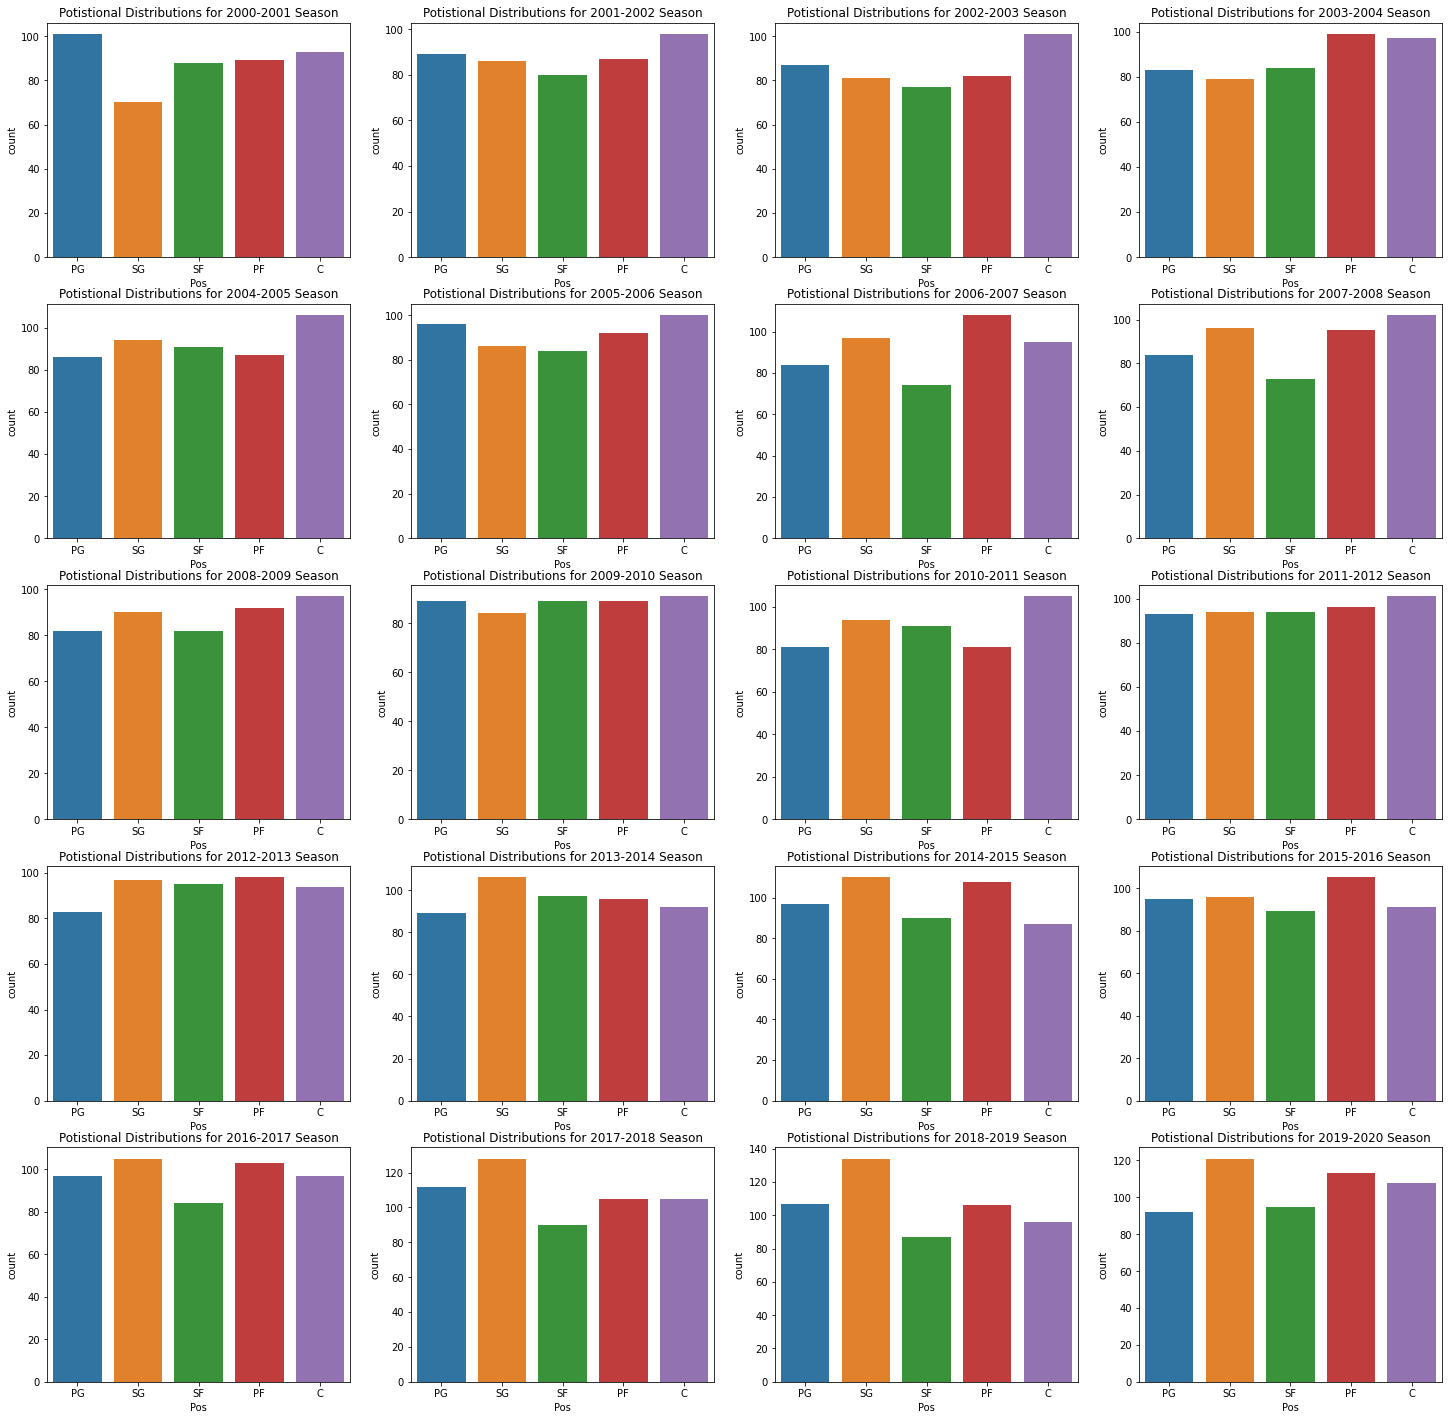

In [5]:
r, c = 5, 4
fig, axes = plt.subplots(r, c, figsize=(25, 25))

seasons = [str(i) + '-' + str(i+1) for i in range(2000, 2020)]

i = 0
for x in range(r):
    for y in range(c):
        sns.countplot(ax=axes[x, y], x='Pos', data=frames[i], order=['PG', 'SG', 'SF', 'PF', 'C'])
        axes[x, y].set_title(f'Potistional Distributions for {seasons[i]} Season')
        i += 1
        
plt.show() 

The above graphs are counplots for each season depicting the distributions of positions, we decided to plot each season individually here in order to best analyze the distribution within a particular season while the aggregate bar plot below is better for seeing the trend in each position over time. From these graphs we can see that the counts for the positions fluctuate where sometimes one postions is played more than another and vice versa. However, we can also see that the shooting guard position increased in the early years and has consistenly stayed higher than other positions in more recent years.

Season,2000-2001,2001-2002,2002-2003,2003-2004,2004-2005,2005-2006,2006-2007,2007-2008,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019,2019-2020
Pos,,,,,,,,,,,,,,,,,,,,
C,93,98,101,97,106,100,95,102,97,91,105,101,94,92,87,91,97,105,96,108
PF,89,87,82,99,87,92,108,95,92,89,81,96,98,96,108,105,103,105,106,113
PG,101,89,87,83,86,96,84,84,82,89,81,93,83,89,97,95,97,112,107,92
SF,88,80,77,84,91,84,74,73,82,89,91,94,95,97,90,89,84,90,87,95
SG,70,86,81,79,94,86,97,96,90,84,94,94,97,106,110,96,105,128,134,121


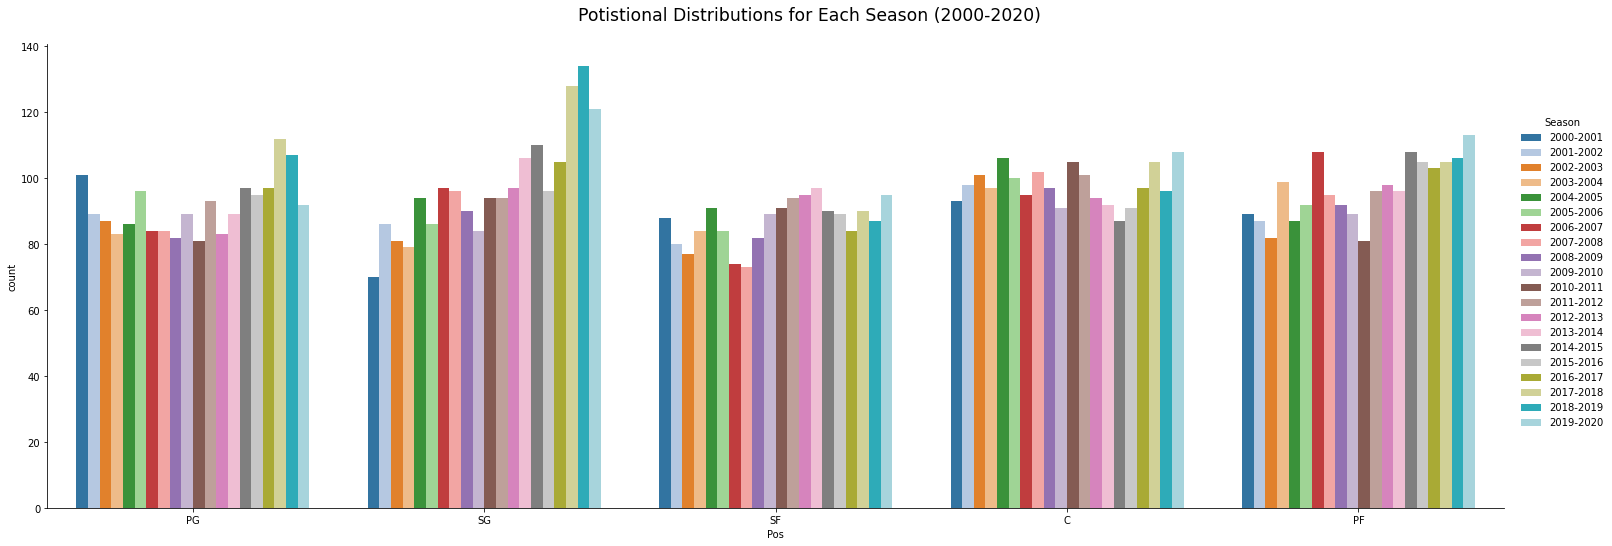

In [6]:
pivot = agg_df.pivot_table(index = 'Pos', columns ='Season' ,
                       aggfunc = 'count', values = 'Tm').fillna(0)

g = sns.catplot(x='Pos', hue="Season", 
          data=agg_df, palette='tab20',
            kind="count", height=7, aspect=3, orient = "h", legend = True, legend_out = True);

plt.suptitle("Potistional Distributions for Each Season (2000-2020)", y =1.05,fontsize='xx-large');
pivot

From this graph and the pivot table above we can see that the shooting guard position has a left skewed exponential distibution and has had an over all increase from the 2000-2001 season to the 2019-2020 season, whereas the small forward and center postions have relatively stayed the same (slightly uniform). The point guard and power forward positions have also had slight increases as shown with their left skewed exponential distibutions while the other positions appear more as slightly uniform distributions.

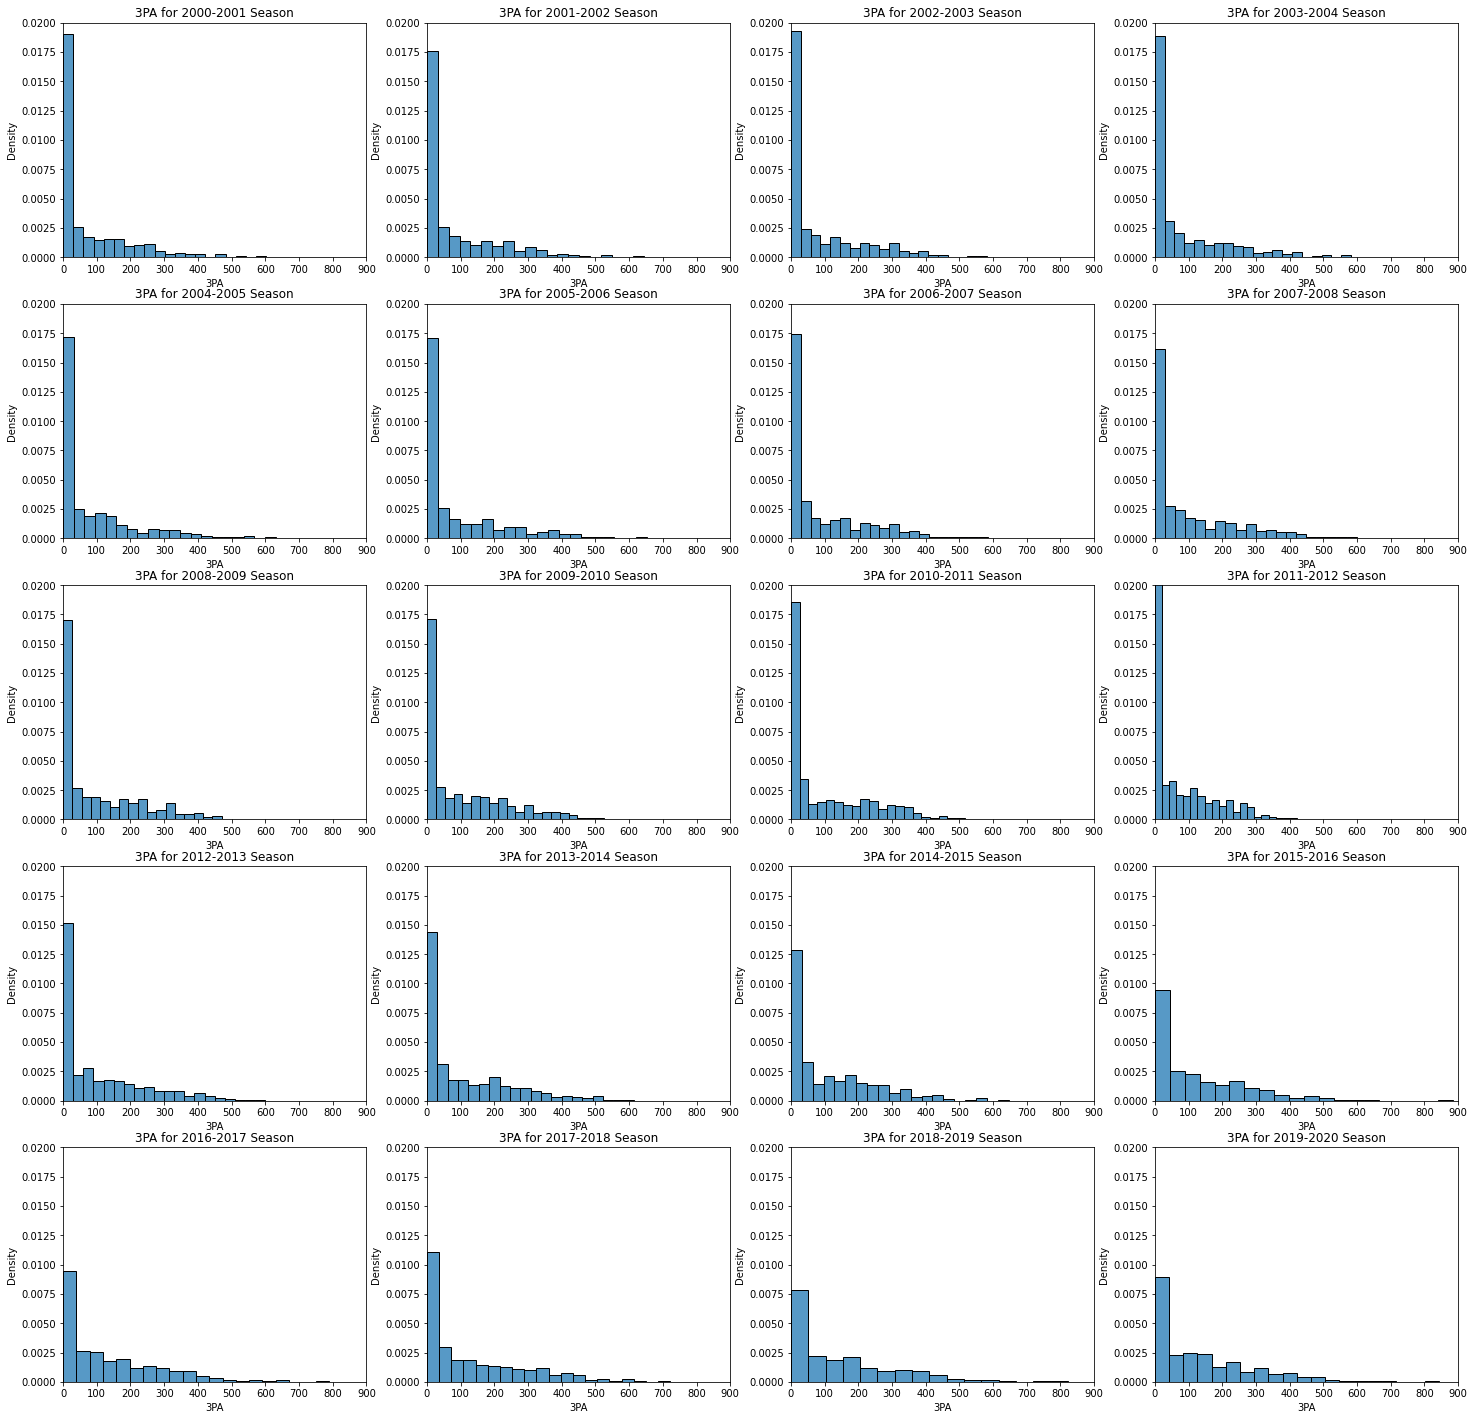

In [7]:
r, c = 5, 4
fig, axes = plt.subplots(r, c, figsize=(25, 25))

seasons = [str(i) + '-' + str(i+1) for i in range(2000, 2020)]

i = 0
for x in range(r):
    for y in range(c):
        sns.histplot(ax=axes[x, y], x='3PA', data=frames[i], stat='density', bins=20)
        axes[x, y].set_ylim([0, .02])
        axes[x, y].set_xlim([0, 900])
        axes[x, y].set_title(f'3PA for {seasons[i]} Season')
        i += 1
        
plt.show()

From the histograms above we can see that the three point attempts have increased overall, and that there has been right skewed exponential distributions amongst the seasons.

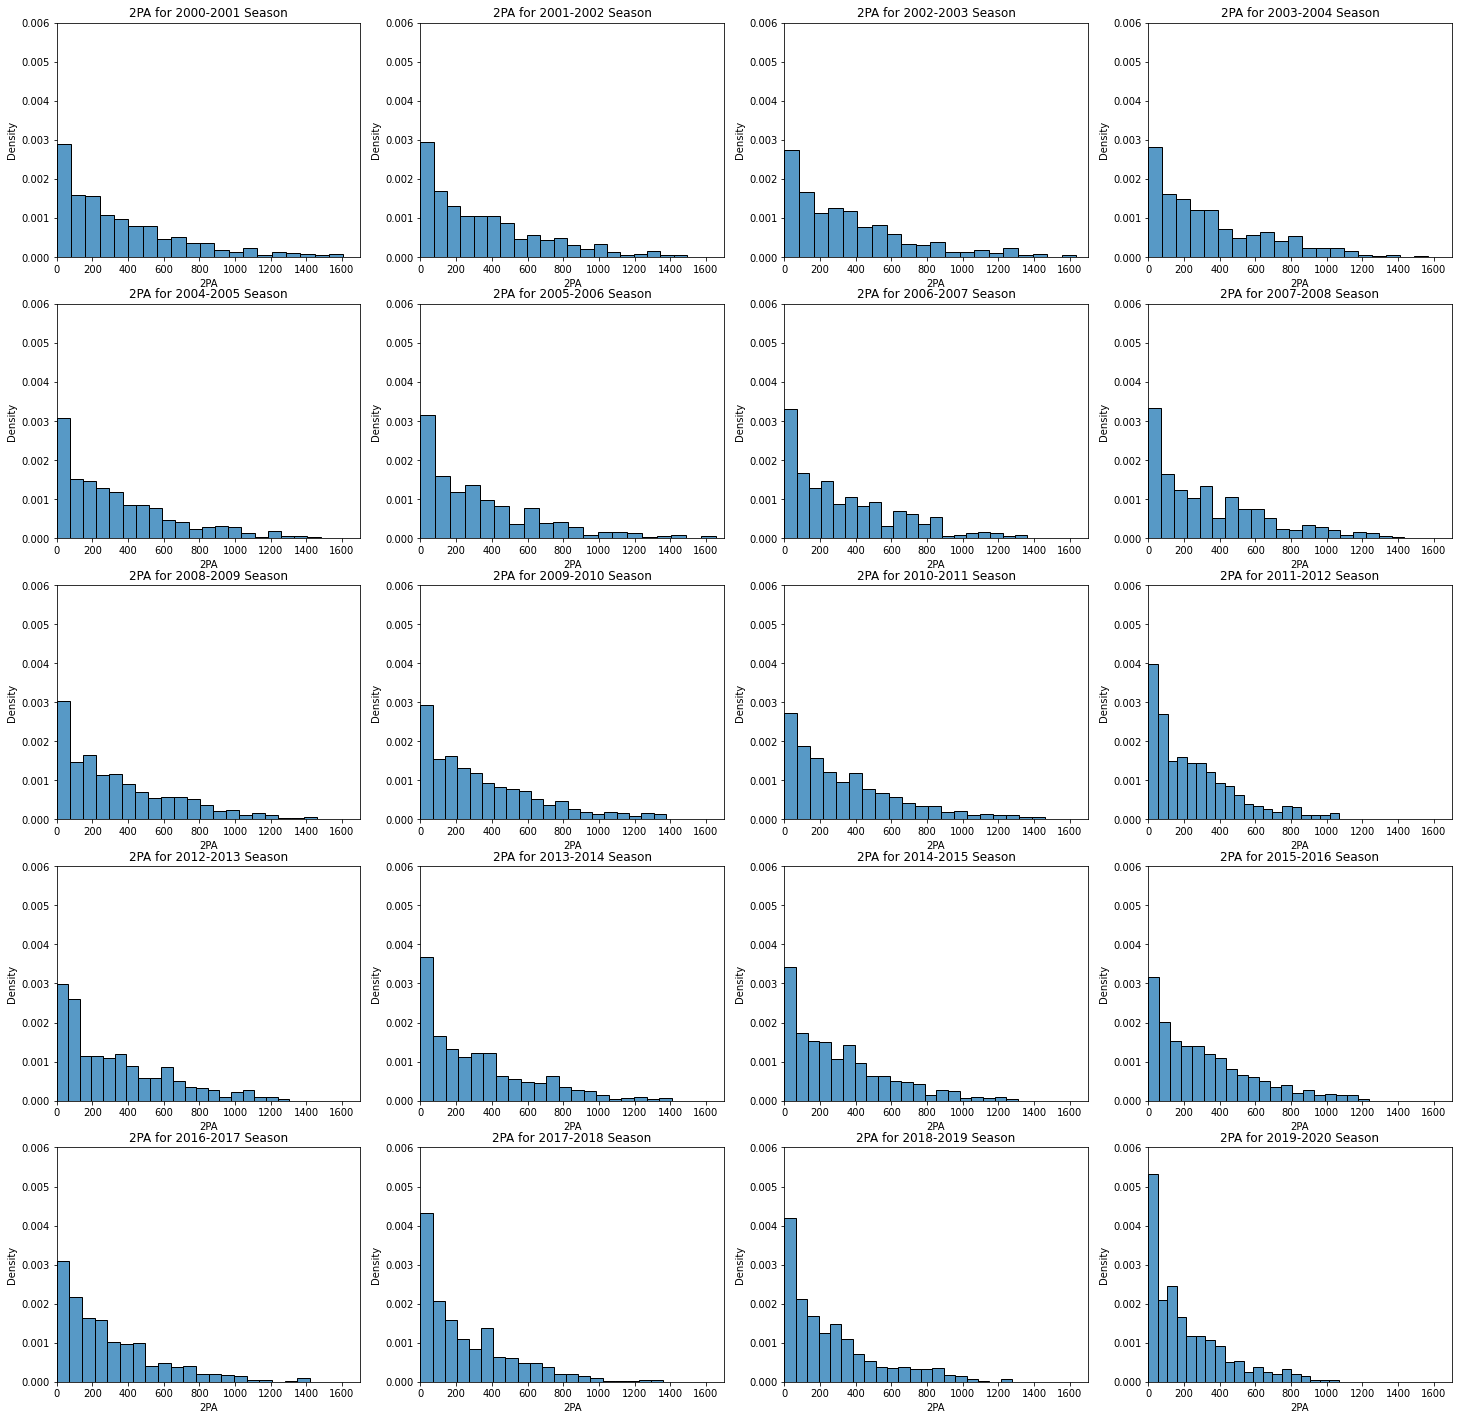

In [8]:
r, c = 5, 4
fig, axes = plt.subplots(r, c, figsize=(25, 25))

seasons = [str(i) + '-' + str(i+1) for i in range(2000, 2020)]

i = 0
for x in range(r):
    for y in range(c):
        sns.histplot(ax=axes[x, y], x='2PA', data=frames[i], stat='density', bins=20)
        axes[x, y].set_ylim([0, .006])
        axes[x, y].set_xlim([0, 1700])
        axes[x, y].set_title(f'2PA for {seasons[i]} Season')
        i += 1
        
plt.show()

From the histograms above we can see that the two point attempts have decreased overall, and that there has been right skewed exponential distributions amongst the seasons.

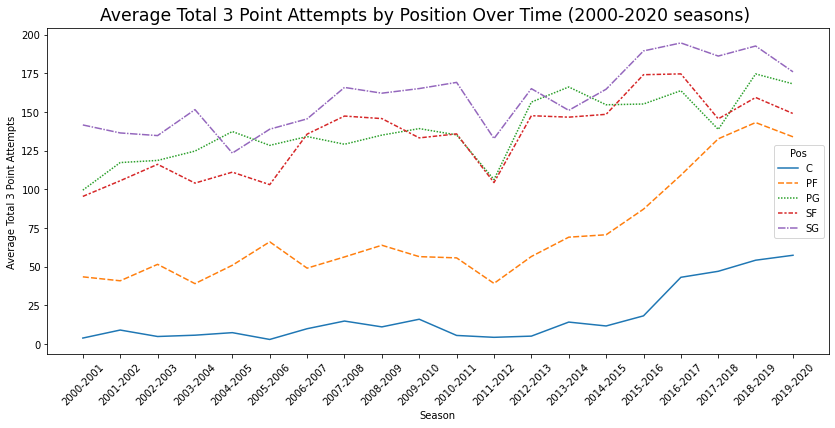

In [9]:
tmp = agg_df.groupby(["Season","Pos"]).mean()['3PA'].reset_index()
pvt = tmp.pivot("Season", "Pos", '3PA')
plt.figure(figsize = (14,6))
sns.lineplot(data=pvt);
plt.xticks(rotation=45);
plt.suptitle("Average Total 3 Point Attempts by Position Over Time (2000-2020 seasons)", y =.93, fontsize='xx-large');
plt.xlabel("Season")
plt.ylabel("Average Total 3 Point Attempts");

From the aggregate line plot above we can see that the average three point attempts for all positions has increased over the years, but most notably for the power foward position which had the most increase starting from 2010-2011 and secondly the center postion which had signficant increase starting from 2014-2015. It is important to note that the 2011-2012 season was shortened to 66 games due to the NBA lockout and the 2019-2020 season varied from 65 to 75 due to a shortened season caused by COVID-19. As a result, those years experienced lower numbers.

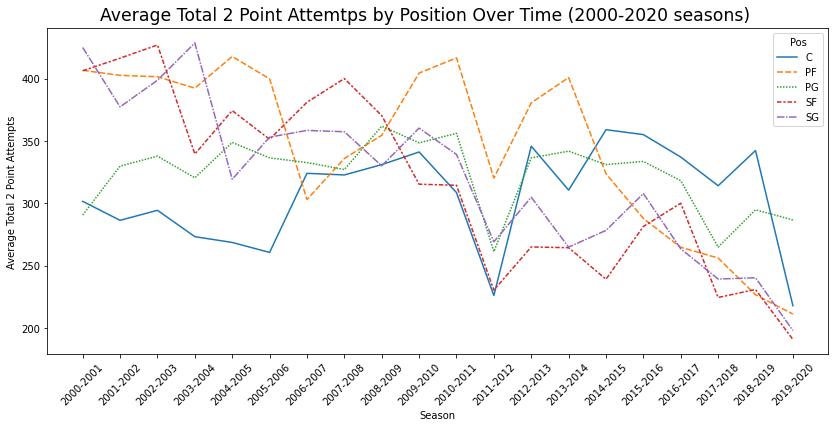

In [10]:
tmp = agg_df.groupby(["Season","Pos"]).mean()['2PA'].reset_index()
pvt = tmp.pivot("Season", "Pos", '2PA')
plt.figure(figsize = (14,6))
sns.lineplot(data=pvt);
plt.xticks(rotation=45);
plt.suptitle("Average Total 2 Point Attemtps by Position Over Time (2000-2020 seasons)", y =.93, fontsize='xx-large');
plt.xlabel("Season")
plt.ylabel("Average Total 2 Point Attempts");

Contrary to the average three point attempts, the average two point attempts has decreased. Since players are taking more attempts at the three point shots, it is natural that we see the average two point attempts go down. It is important to note that the 2011-2012 season was shortened to 66 games due to the NBA lockout and the 2019-2020 season varied from 65 to 75 due to a shortened season caused by COVID-19. As a result, those years experienced lower numbers.

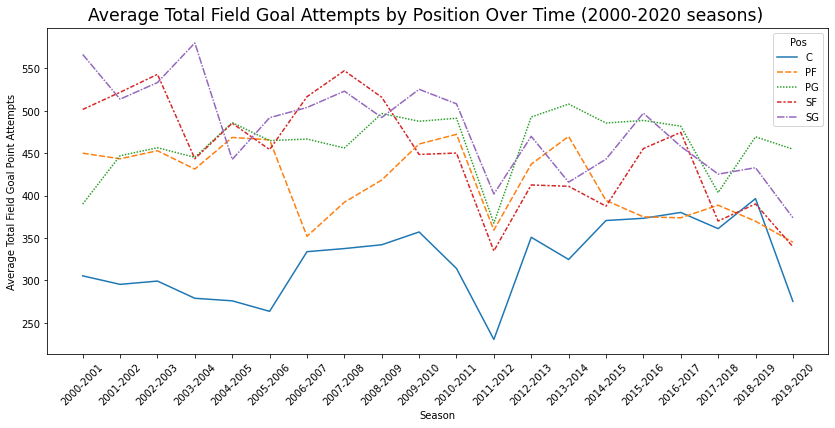

In [11]:
tmp = agg_df.groupby(["Season","Pos"]).mean()['FGA'].reset_index()
pvt = tmp.pivot("Season", "Pos", 'FGA')
plt.figure(figsize = (14,6))
sns.lineplot(data=pvt);
plt.xticks(rotation=45);
plt.suptitle("Average Total Field Goal Attempts by Position Over Time (2000-2020 seasons)", y =.93, fontsize='xx-large');
plt.xlabel("Season")
plt.ylabel("Average Total Field Goal Point Attempts");

The average total field goal attempts has decreased over time for the small forward, shooting guard, and power forward positions. For the center and point guard positions, the average total field goal attempts have gradually increased, however, we do see a sharp decrease in the FGA for center position in the last season. It is important to note that the 2011-2012 season was shortened to 66 games due to the NBA lockout and the 2019-2020 season varied from 65 to 75 due to a shortened season caused by COVID-19. As a result, those years experienced lower numbers.

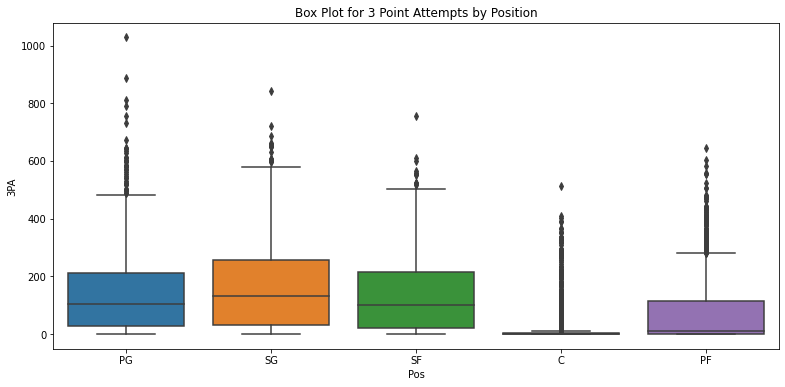

In [12]:
plt.figure(figsize = (13,6))
sns.boxplot(x="Pos", y="3PA", data=agg_df).set_title("Box Plot for 3 Point Attempts by Position");

This boxplot portrays the distribution of three point field goal attempts by position. There is a vast difference among positions here as centers (C) rarely shoot three pointers. Meanwhile, shooting guards (SG) shoot the highest amount of three pointers. There are many outliers on the upper ends of the distributions, particularly among centers, power forwards, and point guards.

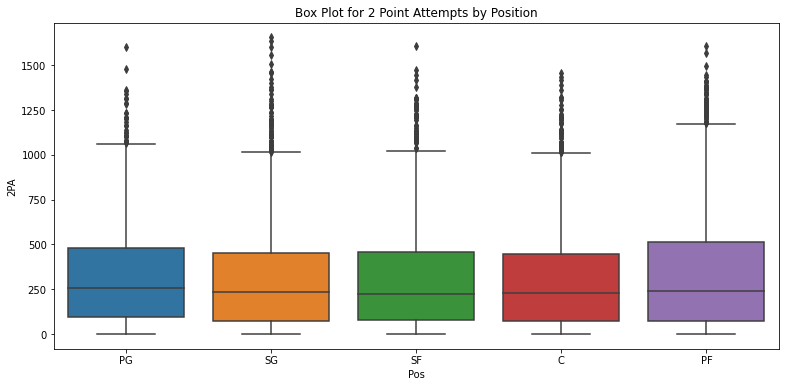

In [13]:
plt.figure(figsize = (13,6))
sns.boxplot(x="Pos", y="2PA", data=agg_df).set_title("Box Plot for 2 Point Attempts by Position");

This boxplot portrays the distribution of two point field goal attempts by position. The data is skewed right (many bench players do not get as much playing time). There are many outliers on the higher end of the distribution for each position. The data for all positions is relatively similar (esp the medians). The power forward (PF) position has a notably high range compared to the other positons.

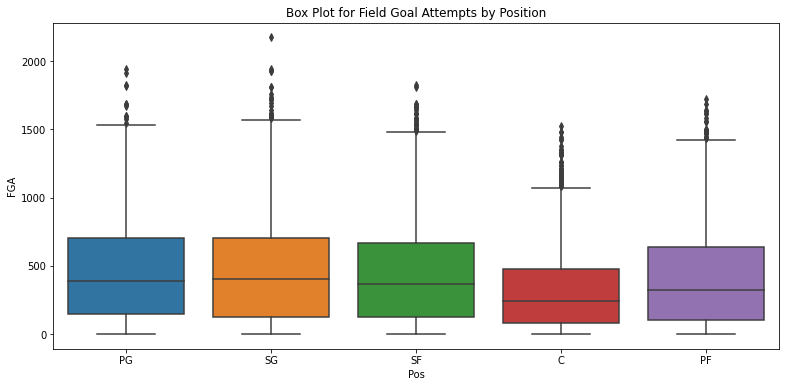

In [14]:
plt.figure(figsize = (13,6))
sns.boxplot(x="Pos", y="FGA", data=agg_df).set_title("Box Plot for Field Goal Attempts by Position");

This boxplot portrays the distribution of field goal attempts by position. The data is skewed right (many bench players do not get as much playing time). There are many outliers on the higher end of the distribution for each position. The median for guards (PG, SG) is slightly higher than other positions while the median for centers (C) if the lowest among all positions.

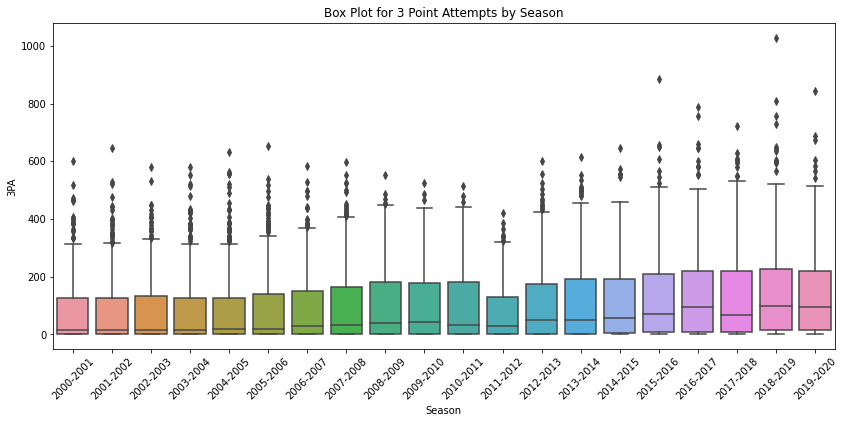

In [15]:
plt.figure(figsize = (14,6))
plt.xticks(rotation=45);
sns.boxplot(x="Season", y="3PA", data=agg_df).set_title("Box Plot for 3 Point Attempts by Season");

This boxplot portrays each player's total number of three point field goal attempts by season. We can see that the data is skewed right and there are considerable outliers on the higher end of the values. It is important to note that the 2011-2012 season was shortened to 66 games due to the NBA lockout and the 2019-2020 season varied from 65 to 75 due to a shortened season caused by COVID-19.

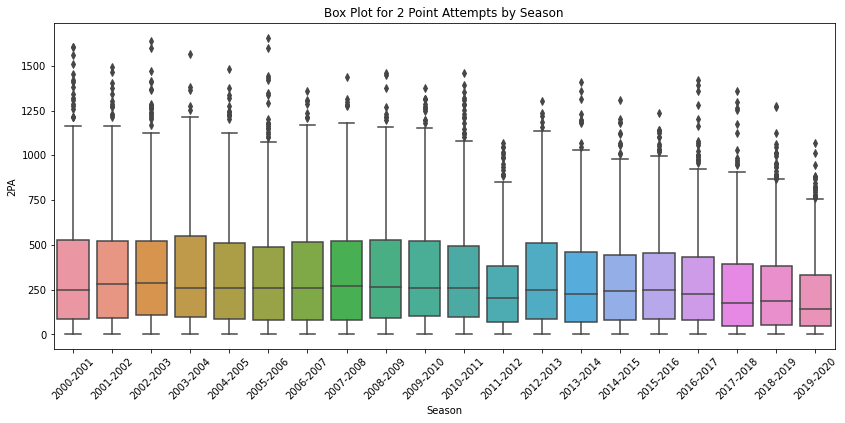

In [16]:
plt.figure(figsize = (14,6))
plt.xticks(rotation=45);
sns.boxplot(x="Season", y="2PA", data=agg_df).set_title("Box Plot for 2 Point Attempts by Season");

This boxplot portrays each player's total number of two point field goal attempts by season. We can see that the data is skewed right and there are considerable outliers on the higher end of the values. It is important to note that the 2011-2012 season was shortened to 66 games due to the NBA lockout and the 2019-2020 season varied from 65 to 75 due to a shortened season caused by COVID-19.

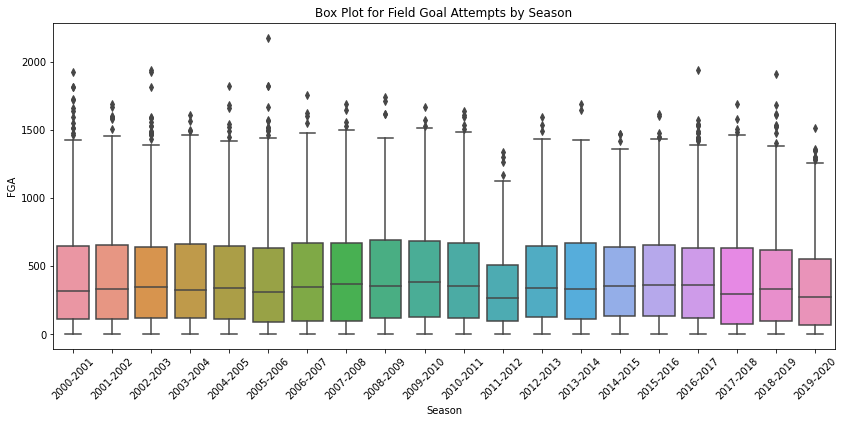

In [17]:
plt.figure(figsize = (14,6))
plt.xticks(rotation=45);
sns.boxplot(x="Season", y="FGA", data=agg_df).set_title("Box Plot for Field Goal Attempts by Season");

This boxplot portrays each player's total number of field goal attempts by season. We can see that the data is skewed right and there are considerable outliers on the higher end of the values. It is important to note that the 2011-2012 season was shortened to 66 games due to the NBA lockout and the 2019-2020 season varied from 65 to 75 due to a shortened season caused by COVID-19.